
# Some advanced topics in units




## Using units with fsolve, odeint, other functions



-   Using units outside of `quantities`, e.g. with fsolve, or odeint will often not work without some extra effort
    -   The best case scenario is you get an error
    -   More often, units will simply be lost or dropped

-   This is a general problem
    -   3<sup>rd</sup> party packages were not designed with `quantities` in mind, and `quantities` cannot know of every 3<sup>rd</sup> party package
    -   This is an issue with *every* units package around
    -   some software packages may be more integrated than others, e.g. Mathematica, or Maple (these are standalone packages)
    -   Other packages, e.g. Matlab, python, or C or Fortran need to be considered carefully

-   It is *however* possible to write "wrapper" functions for using `quantities` with 3<sup>rd</sup> party packages

-   Typically, you store the units going into the problem, if necessary compute the units on the output, and put them back onto the answer.

-   Let us consider some typical problems.




## quantities in fsolve



-   Consider a CSTR with inlet molar flow of 3 mol/min of A at 1 L/min, a rate law of $-r_A = k C_A$, with $k=0.34$ 1/hr. Determine the volume required for 80% conversion of A.

-   We need to solve $0 = F_{A0} - F_A + r_A V$ for $V$.



In [37]:
import quantities as u
import numpy as np
from scipy.optimize import fsolve   # give fsolve a new name

Fa0 = 3 * u.mol / u.min
Fa = Fa0 * (1 - 0.8)
nu = 1 * u.L / u.min
k = 0.34 * 1 / u.hr


def objective(V):
    Ca = Fa / nu
    rA = -k * Ca
    return Fa0 - Fa + rA * V

In [38]:
def wrapperfsolve(func, t0):
    'wrapped fsolve command to work with quantities'
    # store the units on the initial guess
    tU = 1 * t0.units  # units on initial guess, normalized
    print(t0)
    print(tU)
    # wrap the function so it returns a regular number
    def wrapped_func(t):
        't will be unitless, so we add unit to it. t * tU has units.'
        return float(func(t * tU))
    # use the original fsolve with the wrapped function
    sol, = fsolve(wrapped_func, t0)
    # put the original units back on the solution
    print(sol)
    return sol * tU

print(wrapperfsolve(objective, 10*u.L))

10.0 L
1.0 L
705.882352941
705.8823529411767 L


In [22]:
float(1*u.L)

1.0

In [39]:
#print(objective(10 * u.L))

#_fsolve(objective, 10 * u.L)

In [5]:
import quantities as u
from scipy.optimize import fsolve as _fsolve  # give fsolve a new name

Fa0 = 3 * u.mol / u.min
Fa = Fa0 * (1 - 0.8)
nu = 1 * u.L / u.min
k = 0.34 * 1 / u.hr


def objective(V):
    Ca = Fa / nu
    rA = -k * Ca
    return Fa0 - Fa + rA * V


def fsolve(func, t0):
    'wrapped fsolve command to work with quantities'
    # store the units on the initial guess
    tU = 1 * t0.units  # units on initial guess, normalized

    # wrap the function so it returns a regular number
    def wrapped_func(t):
        't will be unitless, so we add unit to it. t * tU has units.'
        return float(func(t * tU))

    # use the original fsolve with the wrapped function
    sol, = _fsolve(wrapped_func, t0)

    # put the original units back on the solution
    return sol * tU

print(fsolve(objective, 10 * u.L))

# Confirm the answer is correct with no units


def objective_nounits(V):
    k = 0.34 / 60.0  # 1/min    A unit conversion by hand
    Fa0 = 3.0       # mol/min
    Fa = Fa0 * (1 - 0.8)
    nu = 1.0
    Ca = Fa / nu
    rA = -k * Ca
    return Fa0 - Fa + rA * V

print(_fsolve(objective_nounits, 10))

705.8823529411767 L
[ 705.88235294]


-   This was an *easy* example because the units on the output of fsolve are the same as the units of the initial guess

-   The fsolve function we wrote does not have all the features of scipy.optimize.fsolve.
    -   You can add those, but it is much more complicated
    -   see [http://kitchingroup.cheme.cmu.edu/blog/2013/03/22/Handling-units-with-the-quantities-module/>](http://kitchingroup.cheme.cmu.edu/blog/2013/03/22/Handling-units-with-the-quantities-module/>)for a more comprehensive example

-   Consider the tradeoffs in this approach
    -   On one hand, we had to wrap a function in a non-intuitive way
    -   We got the units on the answer "for free" after all that work
    -   On the other hand, we did not do *any* unit-conversions by hand
    -   We also did not have to modify our equations

-   PYCSE provides some of this functionality
-   You need the latest version of pycse for this functionality



PYCSE (v1.47+) provides this wrapped function [pycse.qmath.fsolve](https://www.google.com/#safe=off&q=pycse.qmath.fsolve).

-   You should use this with skepticism and engineering judgment
    1.  It has not been used a lot
    2.  Code with units is fragile, and it is possible you will find a way to break it



In [40]:
from pycse.qmath import fsolve
import quantities as u

Fa0 = 3 * u.mol / u.min
Fa = Fa0 * (1 - 0.8)
nu = 1 * u.L / u.min
k = 0.34 * 1 / u.hr


def objective(V):
    Ca = Fa / nu
    rA = -k * Ca
    return Fa0 - Fa + rA * V

print(fsolve(objective, 10 * u.L))

[ 705.88235294] L


-   Let us consider another approach: dimensionless equations.
-   We needed to solve $0 = F_{A0} - F_A - k F_A / \nu V $
-   Let us define a new variable: $G = F_A / F_{A0}$ or $F_A = G F_{A0}$
-   Let us define $\tau = V / \nu$, which is a residence time
-   Finally, note that $k \tau$ is a dimensionless quantity.
    -   Let us call it $D$
-   The equation becomes

$0 = 1 - G - D G $

-   This equation should have only dimensionless quantities.
-   We need to find the value of D that solves it.
-   Then we can compute $V$ with units, as $V = \frac{D \nu}{k}$



In [51]:
from scipy.optimize import fsolve
Fa0 = 3.0                 # mol/min
Fa = Fa0 * (1.0 - 0.8)    # mol/min
G = Fa / Fa0

def objective(D):
    return 1 - G - D * G

Dsol, = fsolve(objective, 1.0)

import quantities as u
nu = 1 * u.L / u.min
k = 0.34 * 1 / u.hr

V = 10 * u.L
tau = V / nu
#print((k * tau))



# V = D * nu / k
V = Dsol * nu / k
print('V = ',V.simplified)
#print('V = ',V)
#print(V.magnitude)
#print(V.units.simplified.units)
#print(V.units.simplified.magnitude)
#print(float(V))

print('Volume = {:1.2f} {}'.format(V.magnitude * V.units.simplified.magnitude, V.units.simplified.units))   # this prints oddly
#                                             # (time/time) because the
                                             # units are not simplified
#print((Dsol * nu / k).simplified)

V =  0.7058823529411767 m**3
Volume = 0.71 1.0 m**3


-   This method has a different set of tradeoffs
    -   We had to derive dimensionless equations
        -   And the result looks trivial to solve in this case
    -   Our dimensionless quantities were easy to check in this case
    -   On the other hand, we did not do any unit conversions at the end
    -   We used the standard fsolve function
    -   We avoided wrapping the function




## quantities in odeint



-   The units on the output of odeint are the units of the initial condition
-   Let us examine a constant volume batch reactor with $-r_A = k C_A$, and $k = 0.0006$ 1/s, and ask what is the concentration of $A$ after 10 minutes if the initial concentration is $C_A(t=0) = 1$ mol / L.

\begin{equation}
\frac{dC_A}{dt} = r_A
\end{equation}




### Analytical solution with no units



-   Here we know the solution $C_A = C_{A0} \exp(-k t)$. We evaluate it for future reference.



In [52]:
import numpy as np
Ca0 = 1
k = 0.0006 * 60     # 1 / min
t = 10              # min
print(Ca0 * np.exp(-k * t))

0.697676326071



### Numerical solution with no units



-   Now we re-solve the problem, using odeint with no units.



In [53]:
import numpy as np
from scipy.integrate import odeint
Ca0 = 1.0
k = 0.0006 * 60  # unit conversion by hand to 1 / min

def dCadt(Ca, t):
    ra = -k * Ca
    return ra

tspan = np.linspace(0, 10) # this is in minutes

sol = odeint(dCadt, Ca0, tspan)
print(sol[-1, 0])

0.697676302326


Same answer. Still no units.




### Using quantities with a wrapped odeint function



-   Let us consider wrapping the odeint function

-   This is subtle. We have make sure the derivative value is scaled to the correct units.
    -   Otherwise the derivative will not be in consistent units, in this case it would be mol / L / s, while the time step would be in minutes
    -   This is not obvious that should have to do that!
    -   That is one very big downside to this approach
    -   And it underscores the need to test new approaches



In [10]:
import quantities as u

a = 10*u.L

print(a.rescale(u.m**3))

0.01 m**3


In [61]:
v=[u.L,u.min]
v.units
list(map(lambda x: x.units,v))

AttributeError: 'list' object has no attribute 'units'

In [62]:
import quantities as u
import numpy as np
from scipy.integrate import odeint as _odeint

Ca0 = 1.0 * u.mol / u.L
k = 0.0006 * 1 / u.s

def dCadt(Ca, t):
    ra  = -k * Ca
    return ra

def odeint(dydx, y0, xspan):
    # get x units
    xU = 1.0 * xspan[0].units
    yU = 1.0 * y0.units

    def wrapped_dydx(y, x):
        v = dydx(y * yU, x * xU).rescale(yU / xU)
        return float(v)

    sol = _odeint(wrapped_dydx, float(y0), [float(x) for x in xspan])
    return sol * yU

tspan = np.linspace(0.0, 10.0)*u.min

sol = odeint(dCadt, Ca0, tspan)
print('The answer is {}'.format(sol[-1, 0]))

The answer is 0.6976763023259455 mol/L


-   We finally get the right answer, with the correct units

-   PYCSE offers a limited support for this.
-   This is a fragile approach, but one that you can check pretty easily.



In [12]:
import quantities as u
import numpy as np
from pycse import odeint

Ca0 = 1.0 * u.mol / u.L
k = 0.0006 * 1 / u.s

def dCadt(Ca, t):
    ra  = -k * Ca
    return ra


tspan = np.linspace(0.0, 600.0) * u.sec


sol = odeint(dCadt, Ca0, tspan)
print(sol[-1, 0])

0.697676302326


-   This last example underscores again the need to be careful when working with units.




# Advanced usage of fsolve



-   We have thus far used fsolve in the simplest way possible.
-   We have used the output of the function, or the success of the function as an indication that it worked
    -   We may also have used the answer in our objective function to confirm we got an answer near zero.



In [64]:
import numpy as np
from scipy.optimize import fsolve

def objective(x):
    return np.exp(x) + 2.0

sol, info, ier, message = fsolve(objective, 0.5, full_output=True)
if ier == 1:
    print(message)
else:
    print('fsolve did not finish correctly. Check your work', ier)

# Note the advanced string formatting in this example
print('''
Nsteps taken = {a[nfev]}
objective(sol) = {a[fvec]}'''.format(a=info))

print('''
Nsteps taken = {0}
objective(sol) = {1}'''.format(info['nfev'], info['fvec']))

print(info)

a = np.array([0, 1, 2, 3, 4])

print('e0: {var[0]}'.format(var=a))

fsolve did not finish correctly. Check your work 5

Nsteps taken = 17
objective(sol) = [ 2.]

Nsteps taken = 17
objective(sol) = [ 2.]
{'nfev': 17, 'fjac': array([[ 1.]]), 'r': array([  5.67615265e-15]), 'qtf': array([ 2.]), 'fvec': array([ 2.])}
e0: 0


In [65]:
message

'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'

-   This kind of information is especially helpful in longer programs, or when you embed fsolve in a loop
-   You can use programming to catch errors and handle them gracefully
    -   This is outside the scope of this course

-   There are many more options to consider with fsolve that control a variety of properties.

[scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)



In [66]:
from scipy.optimize import fsolve
print(help(fsolve))

Help on function fsolve in module scipy.optimize.minpack:

fsolve(func, x0, args=(), fprime=None, full_output=0, col_deriv=0, xtol=1.49012e-08, maxfev=0, band=None, epsfcn=None, factor=100, diag=None)
    Find the roots of a function.
    
    Return the roots of the (non-linear) equations defined by
    ``func(x) = 0`` given a starting estimate.
    
    Parameters
    ----------
    func : callable ``f(x, *args)``
        A function that takes at least one (possibly vector) argument.
    x0 : ndarray
        The starting estimate for the roots of ``func(x) = 0``.
    args : tuple, optional
        Any extra arguments to `func`.
    fprime : callable(x), optional
        A function to compute the Jacobian of `func` with derivatives
        across the rows. By default, the Jacobian will be estimated.
    full_output : bool, optional
        If True, return optional outputs.
    col_deriv : bool, optional
        Specify whether the Jacobian function computes derivatives down
        th

See [http://kitchingroup.cheme.cmu.edu/blog/category/nonlinear-algebra/>](http://kitchingroup.cheme.cmu.edu/blog/category/nonlinear-algebra/>)for many examples of using fsolve in python.

-   Finally, you may be interested in another solver that has more advanced features [scipy.optimize.root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html)
-   It is similar to fsolve, but offers more flexibility in the methods

[scipy.optimize.root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html)



In [15]:
from scipy.optimize import root
print(help(root))

Help on function root in module scipy.optimize._root:

root(fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None)
    Find a root of a vector function.
    
    Parameters
    ----------
    fun : callable
        A vector function to find a root of.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its Jacobian.
    method : str, optional
        Type of solver.  Should be one of
    
            - 'hybr'             :ref:`(see here) <optimize.root-hybr>`
            - 'lm'               :ref:`(see here) <optimize.root-lm>`
            - 'broyden1'         :ref:`(see here) <optimize.root-broyden1>`
            - 'broyden2'         :ref:`(see here) <optimize.root-broyden2>`
            - 'anderson'         :ref:`(see here) <optimize.root-anderson>`
            - 'linearmixing'     :ref:`(see here) <optimize.root-linearmixing>`
            - 'diagbroyden'      :ref:`(see here) <opti


## Parameterized fsolve



Suppose we want to solve a nonlinear algebra problem for many values of a parameter.

Let the reaction $A \rightarrow B$ take place in a CSTR with a volume of 10 L, and $r = 2.3 C_A$.

The inlet concentration is 1.5 mol / L of A.

You need to compute the exit conversion for a range of volumetric flows.

We know that we are solving:
$0 = F_{A0} - F_A + r_A V$

We have to resolve this problem *many* times for different values of v0.

Rather than redefine the equation over and over, we parameterize the objective function with an additional argument.



[ 0.0625]
[ 0.12]


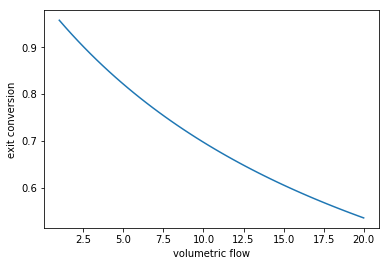

In [16]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

V = 10.0
Ca0 = 1.5

# v0 is a /parameter/
def objective(Ca, v0):
    ra = -2.3 * Ca
    return Ca0 * v0 - Ca * v0 + ra * V

v_array = np.linspace(1, 20)

ig = 0.01  # assume high conversion for initial guess

# we use the parameter like this
print(fsolve(objective, ig, args=(1.0,)))
print(fsolve(objective, ig, args=(2.0,)))


# use list comprehension to do the loop
Ca_exit = [fsolve(objective, ig, args=(v,)) for v in v_array]

X = (Ca0 - np.array(Ca_exit)) / Ca0
plt.plot(v_array, X)
plt.xlabel('volumetric flow')
plt.ylabel('exit conversion')
plt.show()


# Advanced usage of odeint



-   We have also not used the odeint function to its full capacity either
-   We can also get `odeint` to tell us about whether it succeeded or not



In [17]:
import numpy as np
from scipy.integrate import odeint

def dydx(y, x):
    return y

y0 = 1
xspan = np.linspace(0,2)

# Let us get the extra output
sol, infodict = odeint(dydx, y0, xspan, full_output=True)
print(infodict)

print(infodict['message'])

# you can check for success like this
if infodict['message'] != 'Integration successful.':
    print('Something went wrong')
    print(infodict['message'])

{'hu': array([ 0.01536617,  0.03073233,  0.03073233,  0.03073233,  0.03073233,
        0.07070747,  0.07070747,  0.07070747,  0.07070747,  0.07070747,
        0.07070747,  0.07070747,  0.07070747,  0.07070747,  0.07070747,
        0.07070747,  0.1316236 ,  0.1316236 ,  0.1316236 ,  0.10547257,
        0.10547257,  0.10547257,  0.10547257,  0.10547257,  0.10547257,
        0.10547257,  0.10547257,  0.10547257,  0.10547257,  0.10547257,
        0.10547257,  0.10547257,  0.10547257,  0.10547257,  0.10547257,
        0.10547257,  0.10547257,  0.13793568,  0.13793568,  0.13793568,
        0.13793568,  0.13793568,  0.13793568,  0.13793568,  0.13793568,
        0.13793568,  0.13793568,  0.13793568,  0.13793568]), 'tcur': array([ 0.04593084,  0.10739551,  0.13812784,  0.16886017,  0.23032484,
        0.30103231,  0.30103231,  0.37173977,  0.37173977,  0.44244724,
        0.51315471,  0.51315471,  0.58386218,  0.58386218,  0.65456965,
        0.65456965,  0.78619325,  0.78619325,  0.78619325,  

-   the information in infodict may be helpful in debugging problems
-   there are many more options to odeint that may be helpful in some problems

[scipy.integrate.odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)



In [18]:
from scipy.integrate import odeint
help(odeint)

Help on function odeint in module scipy.integrate.odepack:

odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0)
    Integrate a system of ordinary differential equations.
    
    Solve a system of ordinary differential equations using lsoda from the
    FORTRAN library odepack.
    
    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::
    
        dy/dt = func(y, t0, ...)
    
    where y can be a vector.
    
    *Note*: The first two arguments of ``func(y, t0, ...)`` are in the
    opposite order of the arguments in the system definition function used
    by the `scipy.integrate.ode` class.
    
    Parameters
    ----------
    func : callable(y, t0, ...)
        Computes the derivative of y at t0.
    y0 : array
        Initial condition on y (can be a vector).
    t : array
        

See [http://kitchingroup.cheme.cmu.edu/blog/category/ode/>](http://kitchingroup.cheme.cmu.edu/blog/category/ode/>)for many examples of solving ordinary differential equations in python including root finding.



In [88]:
import copy
a=1 

def g(x):
    x+=1
    return x

def f(x,a):
    x+=2
    a+=1
    return x

#print(a)
x=f(1,a)
#print(a)


a=[]
def f(a):
    a=copy.deepcopy(a)
    a.append(0)
    return

print(a)
f(a)
print(a)

[]
[]



# Summary



You should have learned:

1.  How stoichiometry determines changes in the moles of species in a reaction
2.  How the relative rates of species production are related by stoichiometry
3.  Mole balances for a batch reactor, continuously stirred tank reactor, and plug flow reactor
4.  Mole balances for reactors with pressure drops and for reactions that change the total number of moles

You have seen examples of:

1.  solving nonlinear equations
2.  integrating ordinary differential equations